<a href="https://colab.research.google.com/github/FatihSevbanUyanik/Indoor-Transfer-vs-Scratch-VGG/blob/master/Indoor_Transfer_vs_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Indoor Dataset: Transfer vs Scratch (VGG)</h1>
<hr>

In [1]:
!pip3 install torch torchvision

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import os
from torch import nn
from torchvision import transforms
from torch import nn
from torchvision import models
from torchvision import datasets
import warnings
warnings.filterwarnings('ignore')

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# USE THIS CODE CELL TO IMPLEMENT YOUR DATA LOADER
classes = ['bakery', 'bathroom',  'bowling', 'computerroom', 'dining_room', 
           'gym', 'hospitalroom', 'library', 'poolinside', 'toystore']

batch_size = 50
transformation_train = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
 
transformation_valid = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transformation_test = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# importing dataset
# train_dataset = datasets.ImageFolder(root= os.path.join( os.getcwd(), "data" ,"Train"),      transform=transformation_train)
# valid_dataset = datasets.ImageFolder(root= os.path.join( os.getcwd(), "data" ,"Validation"), transform=transformation_valid)
# test_dataset  = datasets.ImageFolder(root= os.path.join( os.getcwd(), "data" ,"Test"),       transform=transformation_test)

organised_data_dir = "/content/drive/My Drive/Organised_Dataset/"
train_dataset = datasets.ImageFolder(root= str(organised_data_dir) + "Train",      transform=transformation_train)
valid_dataset = datasets.ImageFolder(root= str(organised_data_dir) + "Validation", transform=transformation_valid)
test_dataset  = datasets.ImageFolder(root= str(organised_data_dir) + "Test",       transform=transformation_test)

# constructing data loaders.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)

In [6]:
print(train_dataset)
print("----------------------------------------------------")
print(valid_dataset)
print("----------------------------------------------------")
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 1507
    Root location: /content/drive/My Drive/Organised_Dataset/Train
----------------------------------------------------
Dataset ImageFolder
    Number of datapoints: 428
    Root location: /content/drive/My Drive/Organised_Dataset/Validation
----------------------------------------------------
Dataset ImageFolder
    Number of datapoints: 228
    Root location: /content/drive/My Drive/Organised_Dataset/Test


In [0]:
# plots an image.
def convert_img(tensor_image):
    np_image = tensor_image.clone().detach().numpy()
    np_image = np_image.transpose(1, 2, 0)
    mean_3D = np.array((0.5, 0.5, 0.5))
    variance_3D = np.array((0.5, 0.5, 0.5))
    # denormalising image
    np_image = np_image * variance_3D + mean_3D
    np_image = np_image.clip(0, 1)
    return np_image


# plots an image.
def convert_img_cuda(tensor_image):
    np_image = tensor_image.cpu().clone().detach().numpy()
    np_image = np_image.transpose(1, 2, 0)
    mean_3D = np.array((0.5, 0.5, 0.5))
    variance_3D = np.array((0.5, 0.5, 0.5))
    # denormalising image
    np_image = np_image * variance_3D + mean_3D
    np_image = np_image.clip(0, 1)
    return np_image

In [8]:
train_iterator = iter(train_loader)
train_images, train_labels = train_iterator.next()
print( train_images.shape )
print( train_labels.shape )

torch.Size([50, 3, 256, 256])
torch.Size([50])


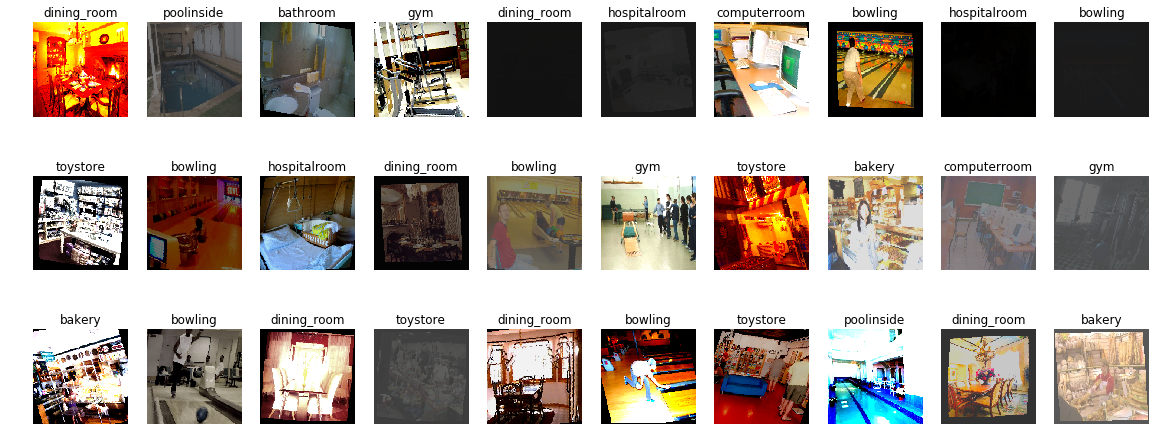

In [9]:
figure = plt.figure(figsize=(20,8))    

for i in range(30):
    axes = figure.add_subplot(3, 10, i+1)
    image = convert_img(train_images[i])
    title = classes[ train_labels[i] ]
    plt.imshow(image) 
    plt.title(title)
    plt.axis('off')

plt.show()

In [0]:
# USE THIS CODE CELL TO DEFINE CNN CLASS

class VGG_Model_Scratch(nn.Module):
    # constructor
    def __init__(self):
        super().__init__()        
        self.model = models.vgg16(pretrained=False)
        last_layer_inputs = self.model.classifier[6].in_features
        last_layer = nn.Linear( last_layer_inputs, 10 )
        self.model.classifier[6] = last_layer
        self.model.to( device )  
  
    def propagate_forward(self, x):
        x = self.model.forward(x)
        return x
  
class VGG_Model_Transfer(nn.Module):
    # constructor
    def __init__(self):
        super().__init__()
    
        self.model = models.vgg16(pretrained=True)
        for feature_extraction_layer in self.model.features.parameters():
            feature_extraction_layer.requires_grad = False

        last_layer_inputs = self.model.classifier[6].in_features
        last_layer = nn.Linear( last_layer_inputs, 10 )
        self.model.classifier[6] = last_layer
        self.model.to( device )

    def propagate_forward(self, x):
        x = self.model.forward(x)
        return x

In [11]:
vgg_model_transfer = VGG_Model_Transfer()
vgg_model_scratch = VGG_Model_Scratch()

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = torch.optim.SGD(vgg_model_transfer.parameters(), lr = 0.01)

criterion_scratch = nn.CrossEntropyLoss()
optimizer_scratch = torch.optim.SGD(vgg_model_scratch.parameters(), lr = 0.01)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:04<00:00, 130326961.97it/s]


In [0]:
def train_model(criterion, optimizer, model):
    train_loss = 0.0
    train_acc = 0.0
  
    # training the model with the train dataset.
    for train_images, train_labels in train_loader:
    
        # registering train images and labels 
        # to device to benefit from GPU
        train_images = train_images.to( device )
        train_labels = train_labels.to( device )
    
        # calculating loss for training
        # dataset for the current batch.
        train_labels_head = model.propagate_forward(train_images)
        loss = criterion(train_labels_head, train_labels)
    
        # updating weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
    
        # calculating acurracy for the current
        # batch for the training dataset.
        predictions = torch.max( train_labels_head , 1)[1] 
        acurracy = torch.sum( predictions == train_labels )
    
        # summing training acurracy and 
        # loss wit the remaining batches.
        train_acc += acurracy 
        train_loss += loss.item()
    
    return train_loss, train_acc


def validate_model(criterion, model):
    valid_loss = 0.0
    valid_acc  = 0.0

    # testing the current model within the current epoch.
    for valid_images, valid_labels in valid_loader:
    
        # registering test images and labels 
        # to device to benefit from GPU
        valid_images = valid_images.to( device )
        valid_labels = valid_labels.to( device )
    
        # calculating loss for test 
        # dataset for the current batch.
        valid_labels_head = model.propagate_forward(valid_images)
        loss = criterion(valid_labels_head, valid_labels)
    
        # calculating acurracy for the cur-
        # rent batch for the test dataset.
        predictions = torch.max( valid_labels_head , 1)[1] 
        acurracy = torch.sum( predictions == valid_labels )
    
        # summing test acurracy and 
        # loss wit the remaining batches.
        valid_acc  += acurracy 
        valid_loss += loss.item()

    return valid_loss, valid_acc

In [13]:
# TRAINING SCRATCH MODEL
numOfEpochs = 80
train_count = 1507
valid_count = 428
train_scratch_losses = []
valid_scratch_losses = []
train_scratch_acurracies = []
valid_scratch_acurracies = []

# training with the number of epochs.
for epoch in range(numOfEpochs):
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0
  
    # training the model with the train dataset.
    train_loss, train_acc = train_model(criterion_scratch, optimizer_scratch, vgg_model_scratch)
    
    # validating the current model within the current epoch.
    valid_loss, valid_acc = validate_model(criterion_scratch, vgg_model_scratch)

    # printing out the training dataset 
    # results for the current batch.
    print("EPOCH --> " + str(epoch + 1))
    print("----------------------------------------------") 

    train_acc = float(train_acc.float()) / train_count
    train_scratch_acurracies.append( train_acc )
    print("Train Acurracy: " + str( float(train_acc) ))
    
    train_loss = train_loss / train_count
    train_scratch_losses.append( train_loss )
    print("Train Loss: " + str(train_loss) + "\n")

    valid_acc = float(valid_acc.float()) / valid_count
    valid_scratch_acurracies.append( valid_acc )
    print("Validation Acurracy: " + str( float(valid_acc) ))    
    
    valid_loss = valid_loss / valid_count
    valid_scratch_losses.append( valid_loss )
    print("Validation Loss: " + str(valid_loss))
    print("----------------------------------------------\n")

EPOCH --> 1
----------------------------------------------
Train Acurracy: 0.16323822163238222
Train Loss: 0.04633515911064325

Validation Acurracy: 0.1658878504672897
Validation Loss: 0.046100048261268116
----------------------------------------------

EPOCH --> 2
----------------------------------------------
Train Acurracy: 0.17584605175846052
Train Loss: 0.045377372034195645

Validation Acurracy: 0.1985981308411215
Validation Loss: 0.045962021729656466
----------------------------------------------

EPOCH --> 3
----------------------------------------------
Train Acurracy: 0.18447246184472463
Train Loss: 0.04502181098725357

Validation Acurracy: 0.19158878504672897
Validation Loss: 0.04550300636024118
----------------------------------------------

EPOCH --> 4
----------------------------------------------
Train Acurracy: 0.18248175182481752
Train Loss: 0.044864445074394035

Validation Acurracy: 0.21728971962616822
Validation Loss: 0.04595995506393575
------------------------------

In [14]:
# TRAINING TRANSFER MODEL
numOfEpochs = 10
train_count = 1507
valid_count = 428
train_losses = []
valid_losses  = []
train_acurracies = []
valid_acurracies  = []

# training with the number of epochs.
for epoch in range(numOfEpochs):
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0
  
    # training the model with the train dataset.
    train_loss, train_acc = train_model(criterion_transfer, optimizer_transfer, vgg_model_transfer)
  
    # validating the current model within the current epoch.
    valid_loss, valid_acc = validate_model(criterion_transfer, vgg_model_transfer)

    # printing out the training dataset 
    # results for the current batch.
    print("EPOCH --> " + str(epoch + 1))
    print("----------------------------------------------")
  
    train_acc = float(train_acc.float()) / train_count
    train_acurracies.append( train_acc )
    print("Train Acurracy: " + str( float(train_acc) ))
    
    train_loss = train_loss / train_count
    train_losses.append( train_loss )
    print("Train Loss: " + str(train_loss) + "\n")

    valid_acc = float(valid_acc.float()) / valid_count
    valid_acurracies.append( valid_acc )
    print("Validation Acurracy: " + str( float(valid_acc) ))    
    
    valid_loss = valid_loss / valid_count
    valid_losses.append( valid_loss )
    print("Validation Loss: " + str(valid_loss))
    print("----------------------------------------------\n")

EPOCH --> 1
----------------------------------------------
Train Acurracy: 0.39416058394160586
Train Loss: 0.03546255830905259

Validation Acurracy: 0.7710280373831776
Validation Loss: 0.018846292779824445
----------------------------------------------

EPOCH --> 2
----------------------------------------------
Train Acurracy: 0.630391506303915
Train Loss: 0.02419215543584944

Validation Acurracy: 0.780373831775701
Validation Loss: 0.01477562768437038
----------------------------------------------

EPOCH --> 3
----------------------------------------------
Train Acurracy: 0.656934306569343
Train Loss: 0.021052102814783858

Validation Acurracy: 0.8738317757009346
Validation Loss: 0.009653557753451517
----------------------------------------------

EPOCH --> 4
----------------------------------------------
Train Acurracy: 0.6708692767086928
Train Loss: 0.019827152572092666

Validation Acurracy: 0.8644859813084113
Validation Loss: 0.008951933793375425
-------------------------------------

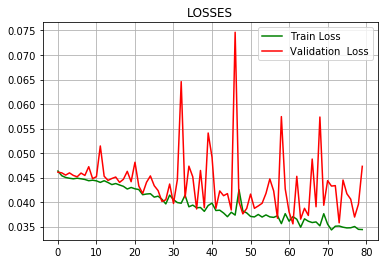

In [15]:
# plotting loss graph for scratch model.
plt.title("LOSSES")
plt.plot(train_scratch_losses, label = "Train Loss", color= "green")
plt.plot(valid_scratch_losses, label = "Validation  Loss", color= "red")
plt.legend()
plt.grid()

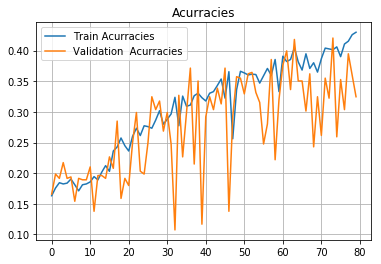

In [16]:
# plotting acurracies graph for scratch model.
plt.title("Acurracies")
plt.plot(train_scratch_acurracies, label = "Train Acurracies")
plt.plot(valid_scratch_acurracies, label = "Validation  Acurracies")
plt.legend()
plt.grid()

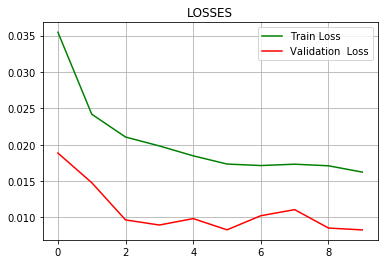

In [17]:
# plotting loss graph for transfer model.
plt.title("LOSSES")
plt.plot(train_losses, label = "Train Loss", color= "green")
plt.plot(valid_losses,  label = "Validation  Loss", color= "red")
plt.legend()
plt.grid()

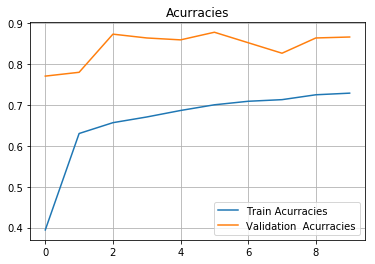

In [18]:
# plotting acurracies graph for transfer model.
plt.title("Acurracies")
plt.plot(train_acurracies, label = "Train Acurracies")
plt.plot(valid_acurracies, label = "Validation  Acurracies")
plt.legend()
plt.grid()

<font>I used cross entropy loss function because of having multiple classification task. Because the model is pretrained in transfer learning, it gets higher and faster results in classifying the rooms. However, the model that is not trained which is the model implemented from scratch does not gives high results and takes long time to train. The learning rates are the same in both models and the epoch count are differents. We have 80 epochs for the untrained model and 10 epochs for the transfer model. Because the scratch model is not trained, it takes more epochs to get consistent results.</font>

In [0]:
def test_model(criterion, model):
    test_loss = 0.0
    test_acc  = 0.0
    test_predcs_all = np.array([])
    test_labels_all = np.array([])
  
    # testing the current model within the current epoch.
    for test_images, test_labels in test_loader: 
    
        # registering test images and labels 
        # to device to benefit from GPU
        test_images = test_images.to( device )
        test_labels = test_labels.to( device )
    
        # calculating loss for test 
        # dataset for the current batch.
        test_labels_head = model.propagate_forward(test_images)
        loss = criterion(test_labels_head, test_labels)
    
        # calculating acurracy for the cur-
        # rent batch for the test dataset.
        predictions = torch.max( test_labels_head , 1)[1] 
        acurracy = torch.sum( predictions == test_labels )
    
        test_predcs_all = np.concatenate((test_predcs_all.ravel(), predictions.cpu().clone().detach().numpy().ravel()))
        test_labels_all = np.concatenate((test_labels_all.ravel(), test_labels.cpu().clone().detach().numpy().ravel()))
    
        # summing test acurracy and 
        # loss wit the remaining batches.
        test_acc  += acurracy 
        test_loss += loss.item()

    return test_loss, test_acc, test_predcs_all, test_labels_all

In [20]:
# testing the transfer model.
test_count = 228
test_loss_transfer, test_acc_transfer, test_pred_transfer, test_labels_transfer = test_model(criterion_transfer, vgg_model_transfer)

test_acc_transfer = float(test_acc_transfer.float()) / test_count 
print("Test Acurracy: " + str( float(test_acc_transfer) ))    
    
test_loss_transfer = test_loss_transfer / test_count
print("Test Loss: " + str(test_loss_transfer))

Test Acurracy: 0.8640350877192983
Test Loss: 0.009185692720245896


In [21]:
# testing the scratch model.
test_count = 228
test_loss_scratch, test_acc_scratch, test_pred_scratch, test_labels_scratch = test_model(criterion_scratch, vgg_model_scratch)

test_acc_scratch = float(test_acc_scratch.float()) / test_count 
print("Test Acurracy: " + str( float(test_acc_scratch) ))    
    
test_loss_scratch = test_loss_scratch / test_count
print("Test Loss: " + str(test_loss_scratch))

Test Acurracy: 0.32456140350877194
Test Loss: 0.04909077757283261


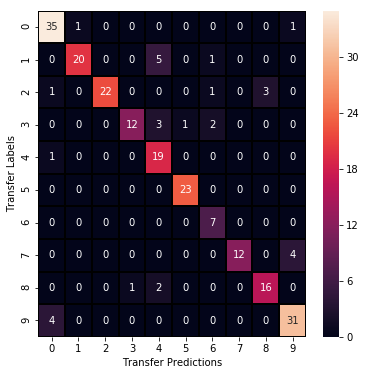

In [22]:
# plotting confusion matrix of transfer model.
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm_transfer = confusion_matrix(test_pred_transfer, test_labels_transfer)

f, ax = plt.subplots(figsize = (6, 6))
sns.heatmap(cm_transfer, annot = True, linewidths=1, linecolor='black', fmt='.0f', ax=ax)
plt.xlabel("Transfer Predictions")
plt.ylabel("Transfer Labels")
plt.show()

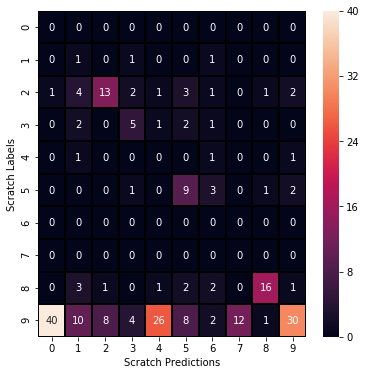

In [23]:
# plotting confusion matrix of scratch model.
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm_scratch = confusion_matrix(test_pred_scratch, test_labels_scratch)

f, ax = plt.subplots(figsize = (6, 6))
sns.heatmap(cm_scratch, annot = True, linewidths=1, linecolor='black', fmt='.0f', ax=ax)
plt.xlabel("Scratch Predictions")
plt.ylabel("Scratch Labels")
plt.show()

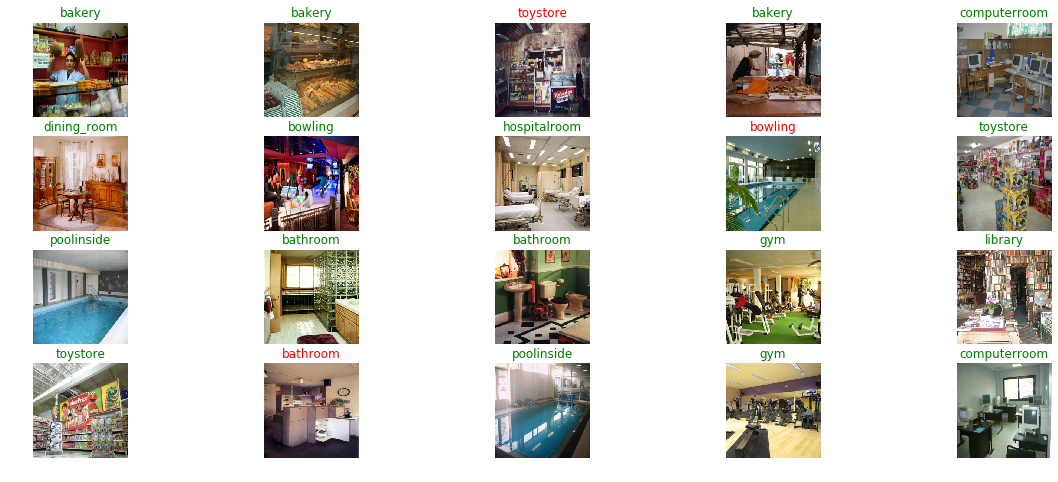

In [25]:
# testing transfer model.
sample_iterator_transfer = iter(test_loader)
sample_images_transfer, sample_labels_transfer = sample_iterator_transfer.next()
sample_images_transfer = sample_images_transfer.to( device )
sample_labels_transfer = sample_labels_transfer.to( device )
sample_labels_transfer_head = vgg_model_transfer.propagate_forward(sample_images_transfer)
sample_predictions_transfer = torch.max( sample_labels_transfer_head , 1)[1] 

figure = plt.figure(figsize=(20,8))    

for i in range(20):
    axes = figure.add_subplot(4, 5, i+1)
    image = convert_img_cuda(sample_images_transfer[i])
    title = classes[ int(sample_predictions_transfer[i]) ]
    plt.imshow(image) 
    plt.axis('off')

    if( str( classes[ sample_labels_transfer[i] ] ) == str(classes[ sample_predictions_transfer[i] ] )):
        plt.title(title, color="green")
    else:
        plt.title(title, color="red")
    
plt.show()

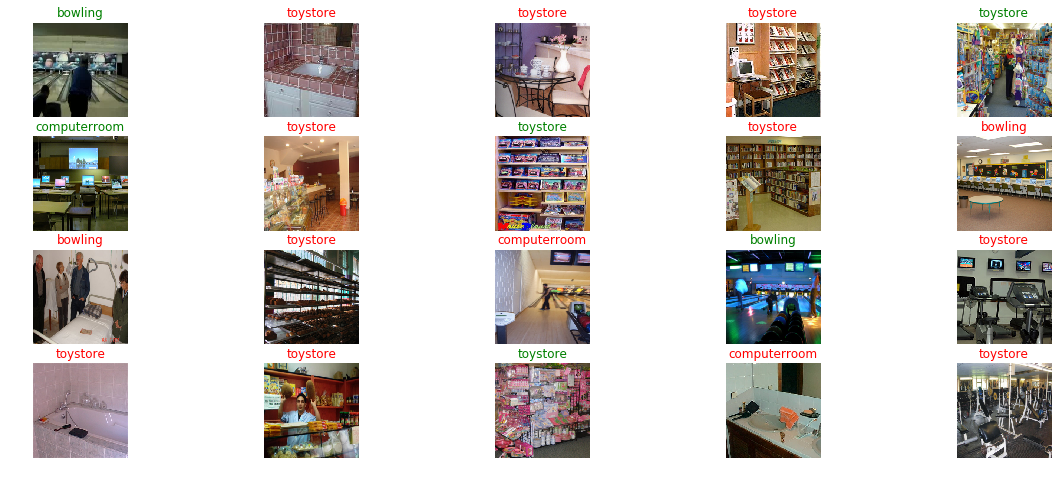

In [26]:
# testing scratch model.
sample_iterator_scratch = iter(test_loader)
sample_images_scratch, sample_labels_scratch = sample_iterator_scratch.next()
sample_images_scratch = sample_images_scratch.to( device )
sample_labels_scratch = sample_labels_scratch.to( device )
sample_labels_scratch_head = vgg_model_scratch.propagate_forward(sample_images_scratch)
sample_predictions_scratch = torch.max( sample_labels_scratch_head , 1)[1] 

figure = plt.figure(figsize=(20,8))    

for i in range(20):
    axes = figure.add_subplot(4, 5, i+1)
    image = convert_img_cuda(sample_images_scratch[i])
    title = classes[ int(sample_predictions_scratch[i]) ]
    plt.imshow(image) 
    plt.axis('off')

    if( str( classes[ sample_labels_scratch[i] ] ) == str(classes[ sample_predictions_scratch[i] ] )):
        plt.title(title, color="green")
    else:
        plt.title(title, color="red")
    
plt.show()

<font>82 percent of acurracy value is obtained by the tansfer learning model and 45 percent acurracy value is obtained by the model that is implemented from scratch. Transfer learning training approach works better because it is trained in advance. This fact gives that model the flexibility to distinguish the differences better.</font>